#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [3]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [4]:
from pathlib import Path
import os
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gdown
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from torch.utils.data import Dataset as TorchDataset
from torchvision.models import resnet18, ResNet18_Weights

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [38]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        #np_obj = np.load(f'/content/drive/MyDrive/{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

Далее к входным изображениям будет применяться нормализация. Для этого посчитаем mean и std для датасета train_tiny.

In [37]:
d_train_tiny = Dataset('train_tiny')

Done. Dataset train_tiny consists of 900 images.


In [7]:
data_mean = []
data_std = []

for i in range(3):
  data_mean.append((d_train_tiny.images[:, :, :, i] / 255).mean())
  data_std.append((d_train_tiny.images[:, :, :, i] / 255).std())

In [8]:
data_mean

[0.7367300652900038, 0.5323509547047984, 0.7040720624187169]

In [9]:
data_std

[0.16750335779032113, 0.21946880199380595, 0.1591425282747252]

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [10]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Модель: resnet18, предобученная на imagenet.

In [11]:
class Model:

    def __init__(self):
        # wrapper for dataset class
        class DatasetWrapper(TorchDataset):
            def __init__(self, dataset, transform=None):

                self.dataset = dataset
                self.transform = transform
                self.length = self.dataset.n_files

            def __len__(self):
                return self.length

            def __getitem__(self, idx):
                image, label = self.dataset.image_with_label(idx)
                label = torch.tensor(label, dtype=torch.long)

                if self.transform is not None:
                    image = self.transform(image)
                else:
                    image = torch.from_numpy(image).permute(2, 0, 1)

                return image, label

        self.dataset_wrapper = DatasetWrapper


        # LBL1
        # transforms
        # Вращения и увеличения отражают вариативность, которая может присутвовать в данных wsi
        self.train_transform =T.Compose([
            T.ToPILImage(),
            T.RandomRotation(degrees=15),
            T.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
            T.RandomApply([T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=0.3),
            T.RandomApply([T.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))], p=0.3),
            T.ToTensor(),
            T.Normalize(mean=data_mean, std=data_std)
        ])

        self.test_transform = T.Compose([
            T.ToPILImage(),
            T.ToTensor(),
            T.Normalize(mean=data_mean, std=data_std)
        ])

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # model
        self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features=in_features, out_features=9, bias=False)

        self.model.to(self.device)

    def save(self, name: str):
        torch.save(self.model.state_dict(), f'/content/drive/MyDrive/{name}.pt')

    def load(self, name: str, checkpoint=False):
        name_to_id_dict = {
            'best': '12BE_ADyZesmnegFoAUMerMX2iVRTuxZQ'
        }
        output = f'{name}.pt'
        gdown.download(f'https://drive.google.com/uc?id={name_to_id_dict[name]}', output, quiet=False)
        self.model.load_state_dict(torch.load(f'{name}.pt'))


    # LBL8
    def load_iteration(self, name, epoch):
        checkpt_name = f'{name}_{epoch}'
        name_to_id_dict = {
            'resnet18_0': '1216h0FcpftiFGvk4ahtvt4ZDmbSsrTjt',
            'resnet18_1': '122uVJ1Az6Zf9wsLMgCC_eywnRFqwpGYF',
            'resnet18_2': '123Q_VX8dNKwvp1y_1B8j9WFunezQOW-_',
            'resnet18_3': '124JdefOavNvTwg12emIqLLYwWja6XCot',
            'resnet18_4': '12A0D1hp_VgkrPiuA-ZaEvO38UJOkQcwv'
        }
        output = f'{name}.pt'
        gdown.download(f'https://drive.google.com/uc?id={name_to_id_dict[checkpt_name]}', output, quiet=False)
        checkpt = torch.load(f'{name}.pt')
        self.model.load_state_dict(checkpt['model_state_dict'])
        print(f'Loaded model from epoch {checkpt["epoch"]}, val_acc={checkpt["acc"] * 100:.2f}%')


    def prepare_dataset(self, dataset, subset='test'):
        if subset == 'test':
          return self.dataset_wrapper(dataset, self.test_transform)
        elif subset == 'train':
          return self.dataset_wrapper(dataset, self.train_transform)


    def train_val_split(self, dataset):
        labels = [label for _, label in dataset]

        train_indices, val_indices = train_test_split(
            np.arange(len(dataset)),
            test_size=0.2,
            stratify=labels,
            random_state=42
        )

        train_subset = Subset(dataset, train_indices)
        val_subset = Subset(dataset, val_indices)

        val_subset.dataset.transform = self.test_transform

        return train_subset, val_subset


    def train_step(self, train_loader, optimizer, loss_fn):
        self.model.train()
        running_loss = 0
        gt = []
        pred = []

        for X, y_true in train_loader:
            optimizer.zero_grad()
            X = X.to(self.device)
            y_true = y_true.to(self.device)

            y_hat = self.model(X)

            loss = loss_fn(y_hat, y_true)

            pred_labels = torch.argmax(y_hat, 1)
            gt.append(y_true.detach().cpu())
            pred.append(pred_labels.detach().cpu())

            running_loss += loss.item() * X.size(0)

            loss.backward()
            optimizer.step()

        gt = torch.cat(gt)
        pred = torch.cat(pred)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = Metrics.accuracy(gt, pred)

        return optimizer, epoch_loss, epoch_accuracy


    def valid_step(self, valid_loader, loss_fn):
        self.model.eval()
        running_loss = 0
        gt = []
        pred = []

        for X, y_true in valid_loader:
            X = X.to(self.device)
            y_true = y_true.to(self.device)

            y_hat = self.model(X)

            loss = loss_fn(y_hat, y_true)

            pred_labels = torch.argmax(y_hat, 1)
            gt.append(y_true.detach().cpu())
            pred.append(pred_labels.detach().cpu())

            running_loss += loss.item() * X.size(0)

        gt = torch.cat(gt)
        pred = torch.cat(pred)
        epoch_loss = running_loss / len(valid_loader.dataset)
        epoch_accuracy = Metrics.accuracy(gt, pred)

        return epoch_loss, epoch_accuracy

    def train(
        self, dataset: Dataset, batch_size,
        n_epochs, Loss_fn, Optimizer, opt_params,
        checkpoint_name, return_plot=False, restart_epoch=None, restart_name=None
    ):
        checkpoint_dir = f'/content/drive/MyDrive/{checkpoint_name}'

        train_full_dataset = self.prepare_dataset(dataset, subset='train')
        # LBL2
        train_data, valid_data = self.train_val_split(train_full_dataset)

        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

        train_losses = []
        valid_losses = []

        train_accuracies = []
        valid_accuracies = []

        loss_fn = Loss_fn()
        optimizer = Optimizer(self.model.parameters(), **opt_params)

        start_epoch = 0
        # LBL7
        if restart_epoch is not None:
          checkpt = torch.load(f'{checkpoint_dir}/{checkpoint_name}_{restart_epoch}.pt')
          optimizer.load_state_dict(checkpt['optimizer_state_dict'])
          self.model.load_state_dict(checkpt['model_state_dict'])
          start_epoch = checkpt['epoch'] + 1
          print(f'Checkpoint loaded. Previous loss={checkpt["loss"]:.4f}, acc={checkpt["acc"] * 100:.2f}%.' \
                f'Restarting from epoch {start_epoch}')
          # Для того, чтобы не затереть изначальные чекпоинты, представленные к сдаче
          checkpoint_dir += restart_name

        if not os.path.isdir(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        for epoch in tqdm(range(start_epoch, n_epochs), desc='Epoch'):
            optimizer, train_loss, train_accuracy = self.train_step(train_loader, optimizer, loss_fn)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            with torch.no_grad():
                valid_loss, valid_accuracy = self.valid_step(valid_loader, loss_fn)
            valid_losses.append(valid_loss)
            valid_accuracies.append(valid_accuracy)

            # LBL3
            print(
                f'Epoch: {epoch + 1} Train loss:{train_loss:.4f} Train accuracy:{train_accuracy * 100:.2f}% || '\
                f'Validation loss:{valid_loss:.4f} Validation accuracy:{valid_accuracy * 100:.2f}%'
            )
            # LBL4
            torch.save({
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': valid_loss,
                'acc': valid_accuracy
            },
                f'{checkpoint_dir}/{checkpoint_name}_{epoch}.pt'
            )

        # LBL5
        if return_plot:
            plt.ioff()
            x = np.arange(n_epochs)
            plt.plot(x, train_losses, label='train loss', color='darkblue', marker='o')
            plt.plot(x, valid_losses, label='validation loss', color='darkgreen', linestyle='--', marker='x')
            plt.plot(x, train_accuracies, label='train accuracy', color='orange', marker='o')
            plt.plot(x, valid_accuracies, label='valid accuracy', color='red', linestyle='--', marker='x')
            plt.xlabel('Эпоха')
            plt.legend(loc='upper left')
            plt.title('Процесс обучения')

            return plt

        return train_losses, valid_losses, train_accuracies, valid_accuracies

    def test_on_dataset(self, dataset: Dataset, batch_size=32, limit=None):
        test_data = self.prepare_dataset(dataset, subset='test')
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

        predictions = []
        self.model.eval()
        for X, y_true in test_loader:
            X = X.to(self.device)
            y_true = y_true.to(self.device)

            with torch.no_grad():
                y_hat = self.model(X)

            pred_labels = torch.argmax(y_hat, 1)
            predictions.extend(list(pred_labels.cpu()))

        return predictions

    def test_on_image(self, img: np.ndarray):
        self.model.eval()

        img = self.test_transform(torch.from_numpy(img).unsqueeze(0))
        with torch.no_grad():
            prediction = self.model(img)
        return prediction


---
### Классификация изображений

Загружаем датасеты для обучения и тестирования.

In [12]:
d_train = Dataset('train')

Done. Dataset train consists of 18000 images.


In [13]:
d_test = Dataset('test')

Done. Dataset test consists of 4500 images.


In [14]:
optimizer = torch.optim.Adam
opt_params = {
    'lr': 1e-4,
    'weight_decay': 1e-4
}
loss_fn = nn.CrossEntropyLoss

In [15]:
checkpoint_name = 'resnet18'

In [16]:
model = Model()

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 Train loss:0.1970 Train accuracy:94.03% || Validation loss:0.0733 Validation accuracy:97.69%
Epoch: 2 Train loss:0.0497 Train accuracy:98.44% || Validation loss:0.0476 Validation accuracy:98.36%
Epoch: 3 Train loss:0.0351 Train accuracy:99.01% || Validation loss:0.0601 Validation accuracy:98.08%
Epoch: 4 Train loss:0.0272 Train accuracy:99.15% || Validation loss:0.0722 Validation accuracy:98.03%
Epoch: 5 Train loss:0.0269 Train accuracy:99.14% || Validation loss:0.0500 Validation accuracy:98.53%


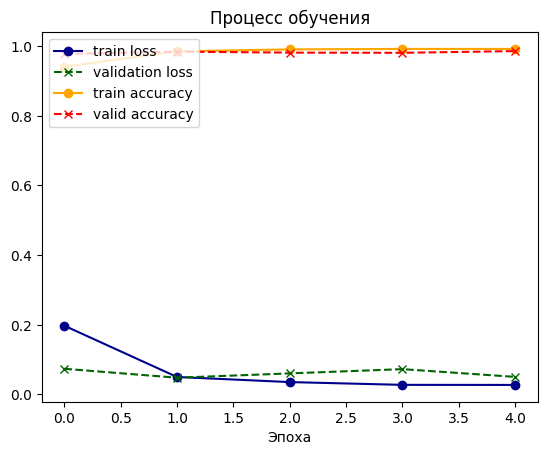

In [17]:
if not EVALUATE_ONLY:
    vis = model.train(d_train, Loss_fn=loss_fn, batch_size=32, n_epochs=5, Optimizer=optimizer,
                      opt_params=opt_params, checkpoint_name=checkpoint_name, return_plot=True)
    model.save('best')
    vis.show()

In [17]:
if EVALUATE_ONLY:
    model.load('best')

Downloading...
From (original): https://drive.google.com/uc?id=12BE_ADyZesmnegFoAUMerMX2iVRTuxZQ
From (redirected): https://drive.google.com/uc?id=12BE_ADyZesmnegFoAUMerMX2iVRTuxZQ&confirm=t&uuid=52589795-133c-4294-a1f4-d93c9752dbd2
To: /content/best.pt
100%|██████████| 44.8M/44.8M [00:00<00:00, 75.6MB/s]
<ipython-input-11-309d4077d8f1>:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_gl

Протестируем модель на полном наборе данных:

In [18]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test, batch_size=32)
    Metrics.print_all(d_test.labels, pred_2, 'test')

metrics for test:
	 accuracy 0.9847:
	 balanced accuracy 0.9847:


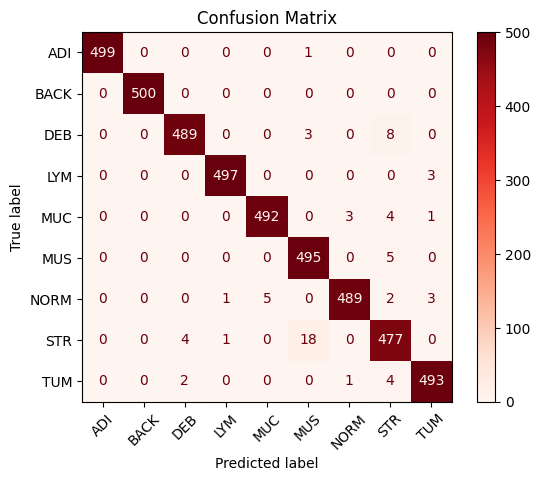

In [19]:
# LBL6

cm = confusion_matrix(d_test.labels, pred_2, labels=np.arange(len(TISSUE_CLASSES)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=TISSUE_CLASSES)
disp.plot(cmap=plt.cm.Reds, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [20]:
precision = precision_score(d_test.labels, pred_2, average=None, labels=np.arange(len(TISSUE_CLASSES)))
recall = recall_score(d_test.labels, pred_2, average=None, labels=np.arange(len(TISSUE_CLASSES)))

print("Precision per class:")
for i, label in enumerate(TISSUE_CLASSES):
    print(f"{label}: {precision[i]:.2f}")

print("\nRecall per class:")
for i, label in enumerate(TISSUE_CLASSES):
    print(f"{label}: {recall[i]:.2f}")

Precision per class:
ADI: 1.00
BACK: 1.00
DEB: 0.99
LYM: 1.00
MUC: 0.99
MUS: 0.96
NORM: 0.99
STR: 0.95
TUM: 0.99

Recall per class:
ADI: 1.00
BACK: 1.00
DEB: 0.98
LYM: 0.99
MUC: 0.98
MUS: 0.99
NORM: 0.98
STR: 0.95
TUM: 0.99


In [21]:
precision_macro = precision_score(d_test.labels, pred_2, average='macro')
recall_macro = recall_score(d_test.labels, pred_2, average='macro')

precision_micro = precision_score(d_test.labels, pred_2, average='micro')
recall_micro = recall_score(d_test.labels, pred_2, average='micro')

precision_weighted = precision_score(d_test.labels, pred_2, average='weighted')
recall_weighted = recall_score(d_test.labels, pred_2, average='weighted')

report = classification_report(d_test.labels, pred_2, target_names=TISSUE_CLASSES)

print("Macro-Averaged Precision:", precision_macro)
print("Macro-Averaged Recall:", recall_macro)
print("Micro-Averaged Precision:", precision_micro)
print("Micro-Averaged Recall:", recall_micro)
print("Weighted Precision:", precision_weighted)
print("Weighted Recall:", recall_weighted)
print("\nClassification Report:\n", report)

Macro-Averaged Precision: 0.9847937364356257
Macro-Averaged Recall: 0.9846666666666667
Micro-Averaged Precision: 0.9846666666666667
Micro-Averaged Recall: 0.9846666666666667
Weighted Precision: 0.9847937364356257
Weighted Recall: 0.9846666666666667

Classification Report:
               precision    recall  f1-score   support

         ADI       1.00      1.00      1.00       500
        BACK       1.00      1.00      1.00       500
         DEB       0.99      0.98      0.98       500
         LYM       1.00      0.99      0.99       500
         MUC       0.99      0.98      0.99       500
         MUS       0.96      0.99      0.97       500
        NORM       0.99      0.98      0.98       500
         STR       0.95      0.95      0.95       500
         TUM       0.99      0.99      0.99       500

    accuracy                           0.98      4500
   macro avg       0.98      0.98      0.98      4500
weighted avg       0.98      0.98      0.98      4500



___
Обучение можно возобновить с некоторой эпохи (для этого предварительно необходимо запустить ячейки для инициализации модели и оптимизатора). !!! Запускать в режиме EVALUATE_ONLY=False, чекпоинты на Вашем диске !!!

In [25]:
model.train(d_train, Loss_fn=loss_fn, batch_size=32, n_epochs=5, Optimizer=optimizer,
            opt_params=opt_params, checkpoint_name=checkpoint_name, return_plot=False, restart_epoch=3, restart_name="new")

<ipython-input-11-ff5eb31fc570>:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpt = torch.load(f'{checkpoint_dir}/{checkpoint_name}_{restart_epoch}.pt')


Checkpoint loaded. Previous loss=0.0722, acc=98.03%.Restarting from epoch 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 5 Train loss:0.0215 Train accuracy:99.38% || Validation loss:0.0511 Validation accuracy:98.39%


([0.02147160485166953], [0.05111714959687864], [0.99375], [0.9838888888888889])

А также можно загрузить веса с некоторой итерации. !!! Запускать в режиме EVALUATE_ONLY=TRUE, чекпоинты в хранилище автора !!!

In [25]:
model.load_iteration('resnet18', 3)
pred = model.test_on_dataset(d_test, batch_size=32)
Metrics.print_all(d_test.labels, pred, 'test')

Downloading...
From (original): https://drive.google.com/uc?id=124JdefOavNvTwg12emIqLLYwWja6XCot
From (redirected): https://drive.google.com/uc?id=124JdefOavNvTwg12emIqLLYwWja6XCot&confirm=t&uuid=0edae671-3583-447d-9203-10c1d4a3160c
To: /content/resnet18.pt
100%|██████████| 134M/134M [00:01<00:00, 88.3MB/s]
<ipython-input-11-309d4077d8f1>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_

Loaded model from epoch 3, val_acc=98.03%
metrics for test:
	 accuracy 0.9771:
	 balanced accuracy 0.9771:


### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [26]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Downloading...
From (original): https://drive.google.com/uc?id=12BE_ADyZesmnegFoAUMerMX2iVRTuxZQ
From (redirected): https://drive.google.com/uc?id=12BE_ADyZesmnegFoAUMerMX2iVRTuxZQ&confirm=t&uuid=0c80758b-f9f3-424c-bb74-fd094185ed82
To: /content/best.pt
100%|██████████| 44.8M/44.8M [00:00<00:00, 77.3MB/s]
<ipython-input-11-309d4077d8f1>:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_gl

Done. Dataset test_tiny consists of 90 images.
metrics for test-tiny:
	 accuracy 0.9556:
	 balanced accuracy 0.9556:


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()